# Homework 2
## Group A 23 - Benjamin Panovich, Dennis Hua, Tianyang Bao, Joseph Padilla 
## 2 Analyzing the Data

In [86]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [87]:
df = pd.ExcelFile(r'C:\Users\jnpad\OneDrive\Desktop\University of Chicago\FINM\03. Autumn Quarter 2022\Portfolio Theory and Risk Management I\Homework\Homework 2\proshares_analysis_data.xlsx')

HFS = pd.read_excel(df, sheet_name = 'hedge_fund_series')
HFS = HFS.set_index('Date')

# Note, we edited excel to include the label "Date" for the date column

factor_data = pd.read_excel(df, sheet_name = 'merrill_factors')
factor_data = factor_data.set_index('Date')

In [88]:
def summary_stats(df, annual_fac):
    report = pd.DataFrame()
    report['Mean'] = df.mean() * annual_fac
    report['Vol'] = df.std() * np.sqrt(annual_fac)
    report['Sharpe'] = report['Mean'] / report['Vol']
    return round(report, 4)

In [89]:
def tail_risk_report(data, q):
    df = data.copy()
    df.index = data.index.date
    report = pd.DataFrame(columns = df.columns)
    
    report.loc['Skewness'] = df.skew()
    report.loc['Excess Kurtosis'] = df.kurtosis()
    report.loc['VaR'] = df.quantile(q)
    report.loc['Expected Shortfall'] = df[df < df.quantile(q)].mean()
    
    cum_ret = (1 + df).cumprod()
    rolling_max = cum_ret.cummax()
    drawdown = (cum_ret - rolling_max) / rolling_max
    report.loc['Max Drawdown'] = drawdown.min()
    report.loc['MDD Start'] = None
    report.loc['MDD End'] = drawdown.idxmin()
    report.loc['Recovery Date'] = None
    
    for col in df.columns:
        report.loc['MDD Start', col] = (rolling_max.loc[:report.loc['MDD End', col]])[col].idxmax()
        recovery_df = (drawdown.loc[report.loc['MDD End', col]:])[col]
        # modify the threshold for recovery from 0 to 0.001
        try:
            report.loc['Recovery Date', col] = recovery_df[recovery_df >= 0].index[0]
            report.loc['Recovery period (days)'] = (report.loc['Recovery Date'] - report.loc['MDD Start']).dt.days

        except:
            report.loc['Recovery Date', col] = None
            report.loc['Recovery period (days)'] = None

    return round(report,4)

In [90]:
def reg_stats(df, annual_fac):
    reg_stats = pd.DataFrame(data = None, index = df.columns, columns = ['beta', 
                                                                         'Treynor Ratio', 
                                                                         'Information Ratio'])
    for col in df.columns:
        # Drop the NAs in y
        y = df[col].dropna()
        # Align the X with y 
        X = sm.add_constant(factor_data['SPY US Equity'].loc[y.index])
        reg = sm.OLS(y, X).fit()
        reg_stats.loc[col, 'beta'] = reg.params[1]
        reg_stats.loc[col, 'Treynor Ratio'] = (df[col].mean() * annual_fac) / reg.params[1]
        reg_stats.loc[col, 'Information Ratio'] = (reg.params[0] / reg.resid.std()) * np.sqrt(annual_fac)

    return reg_stats.astype(float).round(4)

In [91]:
def display_correlation(df,list_maxmin=True):
    
    corrmat = df.corr()
    #ignore self-correlation
    corrmat[corrmat==1] = None
    sns.heatmap(corrmat)

    if list_maxmin:
        corr_rank = corrmat.unstack().sort_values().dropna()
        pair_max = corr_rank.index[-1]
        pair_min = corr_rank.index[0]

        print(f'MIN Correlation pair is {pair_min}')
        print(f'MAX Correlation pair is {pair_max}')

### 1.

Below we display the annualized mean, volatility and Sharpe Ratio for the each of the indices and assets in the Hedge Fund series.

In [107]:
summary_stats(HFS.join(factor_data['SPY US Equity']), 12)

,Mean,Vol,Sharpe
HFRIFWI Index,0.0429,0.0609,0.7038
MLEIFCTR Index,0.0257,0.0569,0.4513
MLEIFCTX Index,0.0243,0.0567,0.4283
HDG US Equity,0.0140,0.0592,0.2365
QAI US Equity,0.0116,0.0489,0.2366
SPY US Equity,0.1213,0.1456,0.8327


### 2. 

Below we display the skewness, excess kurtosis, VaR, CVaR, and max drawdown for each of the indices and assets in the Hedge Fund series. The HFRIFWI Index has notably higher kurtosis than the other indices/assets in the series.

In [105]:
tail_risk_report(HFS.join(factor_data['SPY US Equity']), 0.05)

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity,SPY US Equity
Skewness,-1.020683,-0.315513,-0.304807,-0.298573,-0.634129,-0.413602
Excess Kurtosis,6.163102,1.778696,1.741807,1.931106,1.913339,0.936671
VaR,-0.025585,-0.029652,-0.029867,-0.031528,-0.021245,-0.069215
Expected Shortfall,-0.039205,-0.036865,-0.036763,-0.038482,-0.034401,-0.089169
Max Drawdown,-0.115473,-0.124302,-0.124388,-0.14072,-0.137714,-0.239271
MDD Start,2019-12-31,2021-06-30,2021-06-30,2021-06-30,2021-06-30,2021-12-31
MDD End,2020-03-31,2022-09-30,2022-09-30,2022-09-30,2022-09-30,2022-09-30
Recovery Date,2020-08-31,None,None,None,None,None
Recovery period (days),None,None,None,None,None,None


### 3.

We display the results of regressions of each index/assets against SPY below.

In [106]:
reg_stats(HFS, 12)

,beta,Treynor Ratio,Information Ratio
HFRIFWI Index,0.3500,0.1225,0.0130
MLEIFCTR Index,0.3549,0.0723,-0.7315
MLEIFCTX Index,0.3536,0.0687,-0.7846
HDG US Equity,0.3631,0.0386,-1.1237
QAI US Equity,0.2919,0.0397,-0.9838


### 4.

### (a)

SPY has greater mean, volatility and Sharpe Ratio than the Hedge Fund series. In addition, the kurtosis for SPY is lesser than the other assets, meaning it has lesser tail risk.

The Treynor Ratio measures the excess return per unit of risk assumed by the asset (a sort of reward-to-risk/volatility measure). The Information Ratio compares the return of an asset within a portfolio against a benchmark relative to the risk of the asset against the benchmark. We see that the HFRIFWI Index has a greater Treynor Ratio and Information Ratio in comparison to all the other assets in these regressions. 

The HFRIFWI Index is the only index/asset that has a positive Information Ratio. This indicates that it outperforms the SPY in returns over the data analyzed. The other indices/assets have negative Information Ratios, indicating that they do not outperform the SPY in returns over the data analyzed. 

The betas across the indices/assets are relatively within the same range (~0.30) indicating that SPY accounts for a similar amount of return across the indices/assets.

### (b)

The QAI performs better than HDG as indicated by the Treynor Ratio and Information Ratio. A greater Treynor Ratio means QAI provides greater excess returns per unit of risk assumed or for a given amount of excess returns, the per unit risk is lesser than that of HDG. A greater Information Ratio indicates that QAI performs better against the benchmark (SPY) than does HDG, relative to the risk of QAI against the benchmark, or that for a given amount of return against the benchmark, QAI has lower risk against the benchmark in comparison to HDG. 

It should be noted however, that the positive Treynor Ratio for both QAI and HDG indicate that they have positive excess returns (against the risk free rate), while the negative Informatio Ratio indicates that both QAI and HDG do not outperform SPY.

Additionally, QAI is less correlated to SPY.

### (c)

The most notable properties of the HFRI would be the positive Information Ratio and greater Treynor Ratio. HDG and the ML series do not capture these properties, as they both have negative Information Ratios and their Treynor Ratios are less than that of HFRI.

### 5. 

We display the correlation matrix for these assets below as well as the max and min correlation pairs.

MIN Correlation pair is ('HFRIFWI Index', 'SPY US Equity')
MAX Correlation pair is ('MLEIFCTR Index', 'MLEIFCTX Index')


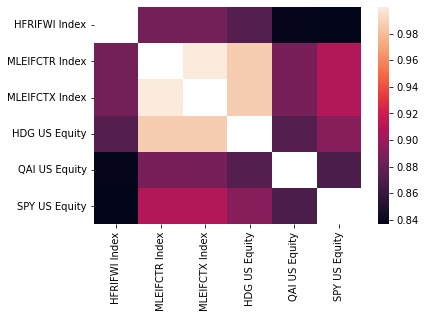

In [96]:
display_correlation(HFS.join(factor_data['SPY US Equity']), True)

### 6. 
### (a)

We run the regression of HFRIFWI Index on each of the six factors and report the intercept and betas below.

In [97]:
y = HFS['HFRIFWI Index']
X = sm.add_constant(factor_data)
static_model = sm.OLS(y,X).fit()

In [98]:
static_model.params.to_frame('Regression Parameters')

,Regression Parameters
const,0.001142
SPY US Equity,0.025589
USGG3M Index,0.834569
EEM US Equity,0.074135
EFA US Equity,0.105604
EUO US Equity,0.023240
IWM US Equity,0.147375


### (b)

The betas seem to be realistic position sizes as the are between 0 and 1 and sum to just over 1 (~1.2). This is to say we neither have to take huge long or short positions but can replicate the HFRIFWI Index with reasonable fractions of an amount invested in each factor, with manageable long/short positions.

### (c)

The R-squared is given by:

In [99]:
round(static_model.rsquared,4)

0.8213

### (d)

The volatility of the tracking error is given by:

In [100]:
round(static_model.resid.std() * np.sqrt(12),4)

0.0258

### 7.

In [101]:
model = RollingOLS(y,X,window=60)
rolling_betas = model.fit().params.copy()
rolling_betas

,const,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
Date,,,,,,,
2011-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2022-05-31,0.004084,0.014981,-2.033076,0.108451,0.115181,0.033973,0.175357
2022-06-30,0.004204,0.011314,-2.009264,0.106422,0.111324,0.028605,0.181174
2022-07-31,0.004532,0.001035,-2.399443,0.118317,0.107350,0.020165,0.176503


In [102]:
rep_IS = (rolling_betas * X).sum(axis=1,skipna=False)
rep_OOS = (rolling_betas.shift() * X).sum(axis=1,skipna=False)
replication = HFS[['HFRIFWI Index']].copy()
replication['Static-IS-Int'] = static_model.fittedvalues
replication['Rolling-IS-Int'] = rep_IS
replication['Rolling-OOS-Int'] = rep_OOS

In [103]:
replication.corr()

,HFRIFWI Index,Static-IS-Int,Rolling-IS-Int,Rolling-OOS-Int
HFRIFWI Index,1.000000,0.906244,0.930242,0.887358
Static-IS-Int,0.906244,1.000000,0.990015,0.986613
Rolling-IS-Int,0.930242,0.990015,1.000000,0.993332
Rolling-OOS-Int,0.887358,0.986613,0.993332,1.000000


<AxesSubplot:xlabel='Date'>

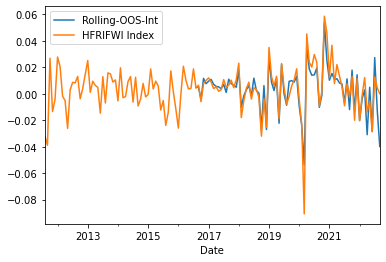

In [77]:
replication[['Rolling-OOS-Int','HFRIFWI Index']].plot()

The OOS replication performs well with respect to the target. There is high correlation between the OOS replication and the HFRIFWI Index.

### 8.
### (a)

In [108]:
y = HFS['HFRIFWI Index']
X = factor_data
static_model_noint = sm.OLS(y,X).fit()

In [109]:
betas = pd.DataFrame(static_model.params,columns=['Yes Intercept']).T
betas.loc['No Intercept'] = static_model_noint.params
betas

,const,SPY US Equity,USGG3M Index,EEM US Equity,EFA US Equity,EUO US Equity,IWM US Equity
Yes Intercept,0.001142,0.025589,0.834569,0.074135,0.105604,0.023240,0.147375
No Intercept,NaN,0.040448,1.551706,0.073052,0.100760,0.024909,0.144352


Without an intercept the betas for SPY, USGG3M, EUO slightly increase indicating that a greater amount of the return on HFRIFWI is explained by these factors. It is difficult to say whether this is a statistically significant result without further analysis, but the regression are fairly similar in performance.

### (b)

In [82]:
print("The mean of the fitted value is", round(static_model_noint.fittedvalues.mean(),4)*12)

The mean of the fitted value is 0.0348


In [84]:
print("The mean of the HFRI is",round(HFS['HFRIFWI Index'].mean(),4)*12)

The mean of the HFRI is 0.0432


The mean of the fitted value approximates the mean of the HFRI, although it is still lesser than HFRI mean.

### (c)

In [110]:
replication['Static-IS-NoInt'] = static_model_noint.fittedvalues
replication.corr()

,HFRIFWI Index,Static-IS-Int,Rolling-IS-Int,Rolling-OOS-Int,Static-IS-NoInt
HFRIFWI Index,1.000000,0.906244,0.930242,0.887358,0.905696
Static-IS-Int,0.906244,1.000000,0.990015,0.986613,0.999395
Rolling-IS-Int,0.930242,0.990015,1.000000,0.993332,0.987919
Rolling-OOS-Int,0.887358,0.986613,0.993332,1.000000,0.984103
Static-IS-NoInt,0.905696,0.999395,0.987919,0.984103,1.000000


The correlations of the fitted values without intercept to the HFRI are high and are almost identical to the correlations of the fitted values with intercept. 

Since Merrill and ProShares are trying to replicate a portfolio with high returns with a certain number of assets, it is likely that they fit the replicators without an intercept. They would want the replicators' mean returns in the ETF to match that of the actual portfolio -- adding an intercept distorts this objective.